## Описание проекта

Даны исторические данные о заказах такси в аэропортах. Требуется построить модель для прогнозирования количества заказов такси на следующий час.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import lightgbm as lgb
import warnings

In [2]:
data_taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
data_taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data_taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
data_taxi.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


In [7]:
#Делаем столбец datetime индексом
data_taxi.set_index('datetime',inplace=True)

In [8]:
#Сортируем данные если не отсортированы
if data_taxi.index.is_monotonic == False:
    data_taxi.sort_index(inplace=True)
else:
    print('Данные уже отсортированы в хронологическом порядке.')

Данные уже отсортированы в хронологическом порядке.


In [9]:
#Выполняем ресемплирование
data_taxi = data_taxi.resample('1H').sum()
data_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Выводы по п.1.
1. Загрузили датасет с данными о заказах такси в аэропортах. В датасете представлены данные о количестве заказов такси каждые 10 минут в период с марта по август 2018. 
2. Сделали столбец с датой-временем (datetime) индексом.
3. Данные уже отсортированы в хронологическом порядке, дополнительная сортировка не требуется.
4. Выполнили ресемплирование - поменяли интервал временного ряда с 10 минут на 1 час.

# 2. Анализ

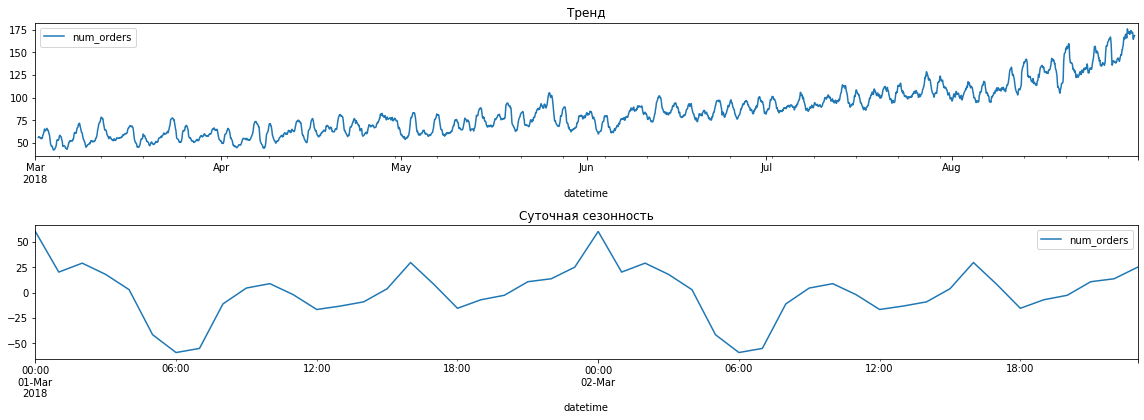

In [10]:
decomposed = seasonal_decompose(data_taxi) 

plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

decomposed.seasonal = decomposed.seasonal['2018-03-01':'2018-03-02']
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
#plt.title('Сезонность')
plt.title('Суточная сезонность')

plt.tight_layout()

In [11]:
rolling_size = 24 #размер окна скользящего среднего - 1 сутки
data_taxi['mean'] = data_taxi['num_orders'].rolling(rolling_size).mean()
data_taxi['std'] = data_taxi['num_orders'].rolling(rolling_size).std()

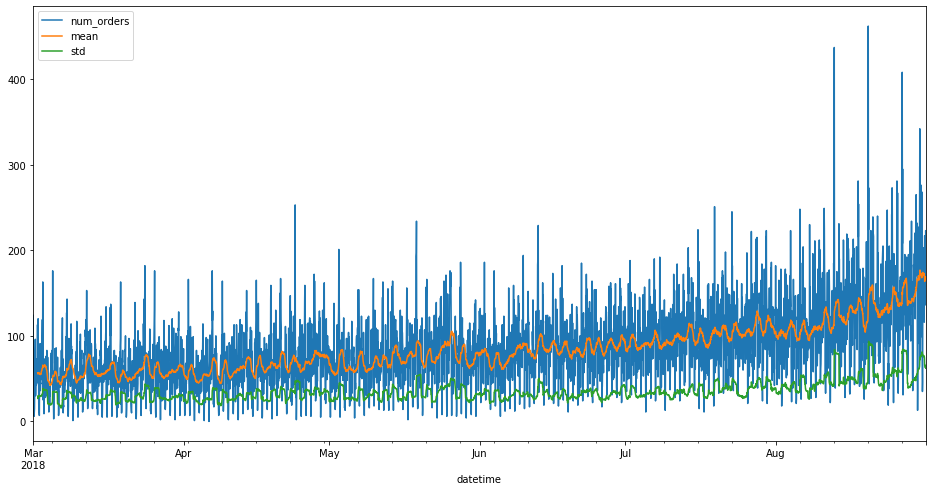

In [12]:
data_taxi.plot(figsize=(16,8))
data_taxi.drop(['mean','std'],axis=1,inplace=True)

In [14]:
#Добавим отстающее на час значение
data_taxi['lag_1'] = data_taxi['num_orders'].shift(1)

In [15]:
#Добавляем календарные признаки
data_taxi['month'] = data_taxi.index.month
data_taxi['day'] = data_taxi.index.day
data_taxi['hour'] = data_taxi.index.hour
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
num_orders    4416 non-null int64
lag_1         4415 non-null float64
month         4416 non-null int64
day           4416 non-null int64
hour          4416 non-null int64
dtypes: float64(1), int64(4)
memory usage: 367.0 KB


In [16]:
data_taxi.head()

,num_orders,lag_1,month,day,hour
datetime,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0
2018-03-01 01:00:00,85,124.0,3,1,1
2018-03-01 02:00:00,71,85.0,3,1,2
2018-03-01 03:00:00,66,71.0,3,1,3
2018-03-01 04:00:00,43,66.0,3,1,4


In [17]:
# Делим датасет на обучающую и тестовую выборки, удаляем пропуски в обучающей, разделяем признаки и целевой признак
train, test = train_test_split(data_taxi, test_size=0.10, random_state=12345,shuffle=False)
print('Обучающая выборка', train.index.min(), train.index.max())
print('Тестовая выборка', test.index.min(), test.index.max())

train = train.dropna()

#СТАРЫЙ КОД - ЗАКОММЕНТИРОВАНО
#feat_train = train.drop('razn', axis=1)
#target_train = train['razn']
#feat_test = test.drop('razn', axis=1)
#target_test = test['razn']

#НОВЫЙ КОД
feat_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

feat_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучающая выборка 2018-03-01 00:00:00 2018-08-13 13:00:00
Тестовая выборка 2018-08-13 14:00:00 2018-08-31 23:00:00


## Выводы по п.2
1. Изучили тренды и сезонность. 

    1.1. Тренд заключается в плавном росте числа заказов такси в течение рассматриваемого периода - с начала марта по конец августа (поскольку летом начинаются отпуска, люди летают чаще). 
    
    1.2. Сезонность связана с суточным периодом - с ноля часов количество заказов начинает снижаться и достигает низшей отметки в шесть часов утра, после чего снова начинает плавно расти, достигая максимальной отметки в 24 часа, с промежуточными снижениями в периоды с 10 до 12 и с 16 до 18 часов. Снижение заказов такси видимо связано с тем, что авиарейсов в эти периоды меньше или нет совсем.


2. Построили график с использованием скользящего среднего с размером окна равным 1 суткам. Временной ряд у нас не стационарный - меняется и среднее, и стандартное отклонение.


3. Добавили признак отстающего на 1 час значения.</font>


4. Добавили 3 новых календарных признака - месяц, день, час.


5. Разделили датасет на обучающую и тестовую (размером 10%) выборки без перемешивания, удалили пропуски в обучающей выборке, разделили признаки и целевой признак.

# 3. Обучение

In [18]:
def RMSECalc(y,predictions):
    rmse = mean_squared_error(y,predictions)**0.5
    return rmse

In [19]:
#Сделали из RMSE свой скор, поскольку для cross_val_score есть только neg_mean_squared_error
my_rmse  = make_scorer(RMSECalc, greater_is_better=False)

In [20]:
#Обучаем модели
#Линейная регрессия
model = LinearRegression()
rmse = cross_val_score(model, feat_train, target_train, scoring=my_rmse, cv=3).mean()
print('Линейная регрессия')
print('RMSE обучающей выборки=',rmse)
print()

Линейная регрессия
RMSE обучающей выборки= -30.848873595322633



In [21]:
#Подбираем оптимальную глубину для решающего дерева
#Оптимальная глубина дерева - 6

for depth in range(1, 32, 5):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    rmse = cross_val_score(model, feat_train, target_train, scoring=my_rmse, cv=3).mean()
    print('max_depth:',depth,'rmse:',rmse)

# берем глубину дерева 6

max_depth: 1 rmse: -38.55130995168539
max_depth: 6 rmse: -31.58668270142086
max_depth: 11 rmse: -33.570505974422964
max_depth: 16 rmse: -35.68322068669457
max_depth: 21 rmse: -35.6578394866887
max_depth: 26 rmse: -35.57729713812447
max_depth: 31 rmse: -35.57729713812447


In [22]:
#Подбираем глубину дерева в случайном лесу
#Оптимальная глубина дерева для случайного леса - 11

for depth in range(1, 32, 5):
    model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=12345)
    rmse = cross_val_score(model, feat_train, target_train, scoring=my_rmse, cv=3).mean()
    print('max_depth:',depth,'rmse:',rmse)

#берем глубину дерева 11

max_depth: 1 rmse: -37.01902862635606
max_depth: 6 rmse: -29.974130063943488
max_depth: 11 rmse: -28.837671359884492
max_depth: 16 rmse: -29.084637803351367
max_depth: 21 rmse: -29.005915882332896
max_depth: 26 rmse: -28.99942266171766
max_depth: 31 rmse: -29.005870203674277


In [23]:
# Подбираем количество деревьев в случайном лесу при глубине дерева = 11
#Оптимальное количество деревьев для случайного леса - 150

for estim in range(50, 251, 50):
    model = RandomForestRegressor(n_estimators=estim, max_depth=11,random_state=12345)
    rmse = cross_val_score(model,feat_train, target_train, scoring=my_rmse, cv=3).mean()
    print('n_estimators:',estim,'rmse:',rmse)

# берем количество деревьев 150

n_estimators: 50 rmse: -28.557114601955757
n_estimators: 100 rmse: -28.487686518172026
n_estimators: 150 rmse: -28.47203474606033
n_estimators: 200 rmse: -28.516305808244244
n_estimators: 250 rmse: -28.47329120863996


In [24]:
#Определяем оптимальную глубину деревьев для CatBoost
#Оптимальная глубина дерева для CatBoost - 6

for best_depth in range(1, 17, 5):
    model = CatBoostRegressor(loss_function = 'RMSE',iterations = 20,verbose = False,depth = best_depth,random_state=12345)
    rmse = cross_val_score(model, feat_train, target_train, scoring=my_rmse, cv=3).mean()
    print('depth:',best_depth,'rmse:',rmse)

# Берем depth = 6

depth: 1 rmse: -39.44188424429734
depth: 6 rmse: -35.56114909187535
depth: 11 rmse: -35.71785376033002
depth: 16 rmse: -36.25215053948167


In [25]:
#Определяем оптимальную скорость для CatBoost
#Оптимальная скорость для CatBoost - 0.5

for best_rate in range(1, 10, 2):
    b_rate = best_rate/10
    model = CatBoostRegressor(loss_function = 'RMSE', iterations = 20, verbose = False, depth = 6, learning_rate = b_rate, random_state=12345)
    rmse = cross_val_score(model, feat_train, target_train, scoring=my_rmse, cv=3).mean()
    print('learning_rate:',b_rate,'rmse:',rmse)

#берем learning_rate = 0.5

learning_rate: 0.1 rmse: -30.289479188626842
learning_rate: 0.3 rmse: -27.55731519748404
learning_rate: 0.5 rmse: -27.489341164905024
learning_rate: 0.7 rmse: -28.477444919124007
learning_rate: 0.9 rmse: -28.327808188003843


In [26]:
#Подбираем оптимальное количество деревьев для LightGBM
#Оптимальная глубина дерева для LightGBM  - 11
warnings.simplefilter("ignore")

d_train = lgb.Dataset(feat_train, label=target_train)
params = {}
params['verbose'] = 0
params['num_rounds'] = 20
params['metric'] = 'rmse'
for best_depth in range(1, 20, 5):
    params['max_depth'] = best_depth
    rmse = lgb.cv(params,d_train,nfold=3)
    print('max_depth:',best_depth,'rmse:',np.mean(rmse['rmse-mean']))
    
#Берем max_depth = 11

max_depth: 1 rmse: 34.17293417089811
max_depth: 6 rmse: 28.118475918322975
max_depth: 11 rmse: 27.708941213089293
max_depth: 16 rmse: 27.709888986007797


In [27]:
#Подбираем оптимальную скорость для LightGBM
#Оптимальная скорость для LightGBM  - 0.5

d_train = lgb.Dataset(feat_train, label=target_train)
params = {}
params['verbose'] = 0
params['num_iterations'] = 20
params['metric'] = 'rmse'
params['max_depth'] = 11
for best_rate in range(1, 10, 2):
    b_rate = best_rate/10
    params['learning_rate'] = b_rate
    rmse = lgb.cv(params,d_train,nfold=3) 
    print('learning_rate:',b_rate,'rmse:',np.mean(rmse['rmse-mean']))
    
#Берем learning_rate = 0.5

learning_rate: 0.1 rmse: 27.708941213089293
learning_rate: 0.3 rmse: 24.142909549811687
learning_rate: 0.5 rmse: 23.755824388850396
learning_rate: 0.7 rmse: 24.017575873992236
learning_rate: 0.9 rmse: 24.812202595219553


## Выводы по п.3
1. Подобрали оптимальные параметры и обучили на обучающей выборке с помощью кросс-валидации 5 моделей: Линейную регрессию, Решающее дерево, Случайный лес, CatBoost, LightGBM.


2. Оценили качество моделей с помощью RMSE. Результаты следующие:
    - Линейная регрессия, RMSE = <font color="gray">~~-29~~</font> <font color="purple">новое значение: -30.84</font>
    - Решающее дерево (max_depth=6), RMSE = <font color="gray">~~-28~~</font> <font color="purple">новое значение: -31.58</font>
    - Случайный лес (n_estimators=150, max_depth=11), RMSE = <font color="gray">~~-25~~</font> <font color="purple">новое значение: -28.47</font>
    - CatBoost (depth=6,learning_rate=0.5), RMSE = <font color="gray">~~-24~~</font> <font color="purple">новое значение: -27.48</font>
    - LightGBM (max_depth = 11,learning_rate=0.5), RMSE = <font color="gray">~~23~~</font> <font color="purple">новое значение: 23.75</font>
    

3. Согласно результатам в качестве лучшей модели выбрали **LightGBM**


# 4. Тестирование

In [28]:
#Проверяем на тесте c подобранными гиперпараметрами
#LightGBM

d_train = lgb.Dataset(feat_train, label=target_train)
params = {}
params['verbose'] = 0
params['num_iterations'] = 20
params['metric'] = 'rmse'
params['max_depth'] = 11
params['learning_rate'] = 0.5
clf = lgb.train(params, d_train, 20)
pred_test = clf.predict(feat_test)
rmse = mean_squared_error(target_test, pred_test)**0.5
print('LightGBM')
print("RMSE тестовой выборки =", rmse)
print()


LightGBM
RMSE тестовой выборки = 42.40112158077376



In [29]:
#константная модель для проверки адекватности
pred_mean = np.full(target_test.shape, target_train.mean())
print("RMSE константной модели:", mean_squared_error(target_test, pred_mean))

RMSE константной модели: 7182.979806808001


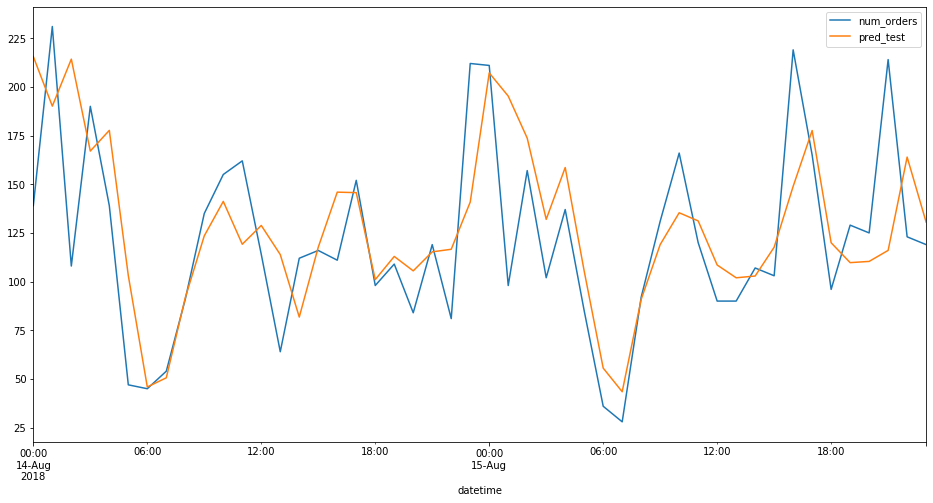

In [30]:
#НОВЫЙ КОД
#строим график факт/предсказанное
data_test = pd.DataFrame(target_test)
data_test['pred_test'] = pred_test.tolist()
data_test[10:58].plot(figsize=(16,8))

## Выводы по п.4
1. Проверили выбранную модель LightGBM на тестовой выборке. RMSE на тестовой выборке = 42.40, что соответствует требованиям проекта (*RMSE должно быть не больше 48*).


2. Проверили модель на адекватность - создали константную модель с предсказаниями по среднему значению целевого признака, замерили ее качество, RMSE константной модели =  7182. Модель прошла проверку на адекватность.


3. Построили график фактических и предсказанных значений.

# Общие выводы
Целью проекта было на основе исторических данных о заказах такси в аэропортах с марта по август 2018 г. построить модель для прогнозирования количества заказов такси на следующий час, с метрикой RMSE не больше 48.

В ходе работы над проектом сделано следующее:

1. Загружены данные из файла, изучены, ресемплированы по одному часу.
2. Данные проанализированы: изучены тренды и сезонность.
3. Данные с количеством заказов заменены данными с разностями временного ряда, рассчитано скользящее среднее с размером окна в 1 сутки.
4. Добавлены новые календарные признаки.
5. Данные разделены на обучающую и тестовую выборки.
6. Обучено несколько моделей с разными гипермпараметрами, по RMSE выбрана лучшая - LightGBM
7. Модель проверена на тестовой выборке, результат удовлетворительный (RMSE = 42.40)

В результате работы построена качественная адекватная модель, прогнозирующая количество заказов такси в следующий час.